# 模型选择


## 验证数据集
从严格意义上讲，测试集只能在所有超参数和模型参数选定后使⽤一次。不可以使用测试数据选择模型，如调参。由于无法从训练误差估计泛化误差，因此也不应只依赖训练数据选择模型。鉴于此，我们可以预留一部分在训练数据集和测试数据集以外的数据来进行模型选择。这部分数据被称为验证数据集，简称验证集（validation set）。

## K折交叉验证 
在 K 折交叉验证中，我们把原始训练数据集分割成 K 个不重合的子数据集，然后我们做K次模型训练和验证。每一次，我们使用一个子数据集验证模型，并使用其他 K-1 个子数据集来训练模型。在这 K 次训练和验证中，每次用来验证模型的子数据集都不同。最后，我们对这 K 次训练误差和验证误差分别求平均。

# 多项式函数拟合实验
模型复杂度和训练数据集⼤小对欠拟合和过拟合的影响，以多项式函数拟合为例来实验。

In [20]:
%matplotlib inline
import torch
import numpy as np
import sys
import d2lzh_pytorch as d2l

## 生成数据集
生成一个人工数据集，给定样本特征为x，使用如下三阶多项式函数来生成该样本的标签：
$$ y=1.2x-3.4x^2+5.6x^3+5+\epsilon $$

In [2]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5

features = torch.randn((n_train+n_test, 1))
# 对x求平方和三次方，并将结果与原值一起拼接成200*3的矩阵
poly_features = torch.cat((features, torch.pow(features, 2), 
                           torch.pow(features, 3)), 1)
labels = (true_w[0] * poly_features[:, 0] + 
         true_w[1] * poly_features[:, 1]+
         true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), 
                      dtype=torch.float)

In [3]:
print(features[:2])
print(poly_features[:2])
print(labels[:2])

tensor([[ 0.3875],
        [-0.9230]])
tensor([[ 0.3875,  0.1502,  0.0582],
        [-0.9230,  0.8518, -0.7862]])
tensor([ 5.2759, -3.4011])


## 定义、训练和测试模型


In [4]:
# 作图函数
def semilogy(x_vals, y_vals, x_label, y_label, 
             x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [7]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
        
    print("final epoch: train loss", train_ls[-1], "test loss", test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

final epoch: train loss 9.97204115265049e-05 test loss 0.0001074738465831615
weight: tensor([[ 1.1988, -3.3998,  5.6002]]) 
bias: tensor([5.0002])


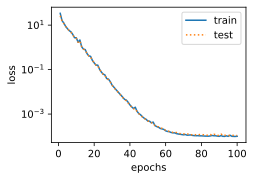

In [11]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], 
            labels[:n_train], labels[n_train:])

再试试线性函数拟合。很明显，该模型的训练误差在迭代早期下降后便便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。线性模型在非线性模型（如三阶多项式函数）生成的数据集上容易欠拟合。

final epoch: train loss 287.6050720214844 test loss 266.01947021484375
weight: tensor([[22.9662]]) 
bias: tensor([-0.9444])


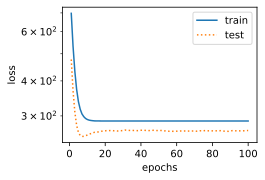

In [13]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

# 权重衰减

权重衰减等价于 范数正则化（regularization）。正则化通过为模型损失函数添加惩罚项使学出的
模型参数值较⼩小，是应对过拟合的常⽤手段。

以高维线性回归为例例来引⼊一个过拟合问题，并使⽤用权重衰减来应对过拟合。设数据样本特
征的维度为 。对于训练数据集和测试数据集中特征为 x1, x2, ..., xp的任一样本，我们使⽤用如下的线性函数来生成该样本的标签：
$$y=0.05+\sum_{i=1}^p0.01x_i+\epsilon$$
其中噪声项 服从均值为0、标准差为0.01的正态分布。为了了较容易易地观察过拟合，我们考虑⾼高维线性回归问题，如设维度p=200 ；同时，我们特意把训练数据集的样本数设低，如20。

In [15]:
%matplotlib inline
import torch.nn as nn

## 建立数据集

In [17]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train,:], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 初始化模型参数

In [18]:
def init_params():
    # 为每个参数都附上梯度
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

## 定义$L_2$范数惩罚项

In [19]:
def l2_penalty(w):
    # 这里只惩罚模型的权重参数
    return (w**2).sum()/2

## 定义训练和测试


In [21]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            # 添加了L2范数惩罚项
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
        
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.27350902557373


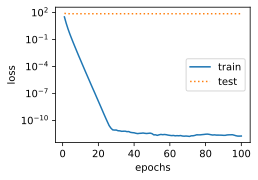

In [22]:
fit_and_plot(lambd=0)  # 没有使用权重衰减

L2 norm of w: 0.033515628427267075


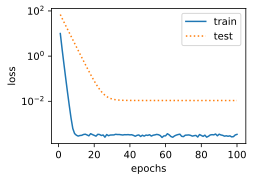

In [23]:
fit_and_plot(lambd=3)

使用Torch框架简单实现

In [33]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    # 对权重参数衰减
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    # 不对偏差参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
            
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
        
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 12.778398513793945


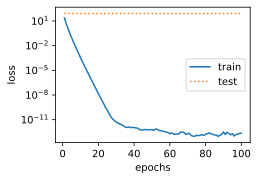

In [34]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.0897851437330246


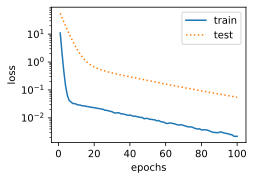

In [35]:
fit_and_plot_pytorch(3)

## 权重衰减小结
* 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
* 权重衰减等价于$L_2$范数正则化，通常会使学到的权重参数的元素较接近0。
* 权重衰减可以通过优化器器中的 weight_decay 超参数来指定。
* 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法。